# Supplementary analysis over `sci-Plex 3`[[1]](https://www.science.org/doi/10.1126/science.aax6234) 

This notebook relies on pre-processed data obtained in [`1_perturbations_sciplex3_preprocessing.ipynb`](https://github.com/nitzanlab/biolord_reproducibility/blob/main/notebooks/perturbations/sciplex3/1_perturbations_sciplex3_preprocessing.ipynb).<br>
Alternatively the processed adata can be downloaded from figshare, [`sciplex3_biolord.h5ad`](https://figshare.com/ndownloader/files/39324305).

Here we load pre-computed evaluations of `biolord` and `chemCPA`[[2]](https://openreview.net/forum?id=vRrFVHxFiXJ) on the `sci-Plex 3`[[1]](https://www.science.org/doi/10.1126/science.aax6234) dataset over different settings:
[]including running over 10 seeds.  

[[1] Srivatsan, S. R., McFaline-Figueroa, J. L., Ramani, V., Saunders, L., Cao, J., Packer, J., ... & Trapnell, C. (2020). Massively multiplex chemical transcriptomics at single-cell resolution. Science, 367(6473), 45-51.](https://www.science.org/doi/10.1126/science.aax6234)

[[2] Hetzel, Leon, Simon Böhm, Niki Kilbertus, Stephan Günnemann, Mohammad Lotfollahi, and Fabian Theis. "Predicting Cellular Responses to Novel Drug Perturbations at a Single-Cell Resolution" Advances in Neural Information Processing Systems (2022).](https://openreview.net/forum?id=vRrFVHxFiXJ)


## load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import torch

import seaborn as sns
import matplotlib.pyplot as plt

import biolord

In [5]:
sys.path.append("../../../")
sys.path.append("../../../utils/")

from paths import DATA_DIR, FIG_DIR

from utils_perturbations_sciplex3 import compute_prediction, compute_baseline, create_df
from parameters_sciplex3 import (
    groups,
    groups_colors,
    module_params,
    trainer_params,
    ood_drugs,
)

## set parameters

In [6]:
import mplscience

mplscience.set_style()

plt.rcParams["legend.scatterpoints"] = 1

In [7]:
DATA_DIR_LCL = DATA_DIR + "/perturbation-celltype/"
FIG_DIR_LCL = FIG_DIR + "/perturbation-celltype/"

## Random `seed` initializations

To compute `seed` results we train models using `scripts/chemCPA` and `scripts/biolord/sciplex3`, modifying the seed parameter.

In [8]:
df_biolord = pd.read_csv(DATA_DIR_LCL + "seed_check_biolord.csv", index_col=0) 
df_biolord["type"] = "biolord"
df_biolord["df_all_mean"] = df_biolord["mean_all_biolord/1.0"]
df_biolord = df_biolord.rename(columns=lambda x: x.replace("mean_all_biolord", "mean_all"))


df_baseline = df_biolord[['mean_all_baseline/0.001', 'mean_all_baseline/0.01', 'mean_all_baseline/0.1', 'mean_all_baseline/1.0']].copy()
df_baseline["type"] = "baseline"
df_baseline["df_all_mean"] = df_biolord["mean_all_baseline/1.0"]
df_baseline = df_baseline.rename(columns=lambda x: x.replace("mean_all_baseline", "mean_all"))

df_chem_pre = pd.read_csv(DATA_DIR_LCL + "seed_check_chemcpa_pretrained_full.csv", index_col=0)
df_chem_pre["type"] = "chemCPA-pre"
df_chem_pre = df_chem_pre.rename(columns=lambda x: x.replace("mean_all_chemCPA", "mean_all"))

df_chem = pd.read_csv(DATA_DIR_LCL + "seed_check_chemcpa_full.csv", index_col=0)
df_chem["type"] = "chemCPA"
df_chem = df_chem.rename(columns=lambda x: x.replace("mean_all_chemCPA", "mean_all"))
df_full = pd.concat([df_baseline, df_chem, df_chem_pre, df_biolord])

In [9]:
df_full = df_full[[
    'mean_all/0.001',
    'mean_all/0.01', 
    'mean_all/0.1', 
    'mean_all/1.0', 
    "type"
]]

In [10]:
df_full.groupby(by=["type"]).mean()

,mean_all/0.001,mean_all/0.01,mean_all/0.1,mean_all/1.0
type,,,,
baseline,0.866243,0.785759,0.631232,0.380029
biolord,0.881238,0.808281,0.725169,0.739689
chemCPA,0.780040,0.723115,0.591426,0.396102
chemCPA-pre,0.878069,0.812955,0.688178,0.507024


In [11]:
df_full.groupby(by=["type"]).var()

,mean_all/0.001,mean_all/0.01,mean_all/0.1,mean_all/1.0
type,,,,
baseline,0.000000,0.000000,0.000000,0.000000
biolord,0.000016,0.000087,0.000088,0.000611
chemCPA,0.032197,0.026237,0.017140,0.006702
chemCPA-pre,0.000081,0.000208,0.000886,0.006211


## Subsampling analysis

We train a biolord model using the procedure in `scripts/biolord/sciplex3` with subsampled anndata file, by taking:
```{python}
adatas = {}
for frac in [0.2, 0.4, 0.6, 0.8]:
    adatas[frac] = sc.pp.subsample(
                        adata, 
                        fraction=fraction_to_keep, 
                        random_state=varying_arg["seed"]
                        )
```



In [12]:
df_ss = pd.read_csv(DATA_DIR_LCL + "fraction_biolord.csv", index_col=0)[['fraction_to_keep', 'mean_all_biolord/0.001', 'mean_all_biolord/0.01',
       'mean_all_biolord/0.1', 'mean_all_biolord/1.0']]

In [13]:
df_ss = pd.melt(df_ss, id_vars=["fraction_to_keep"], value_vars=['mean_all_biolord/0.001', 'mean_all_biolord/0.01',
       'mean_all_biolord/0.1', 'mean_all_biolord/1.0'])


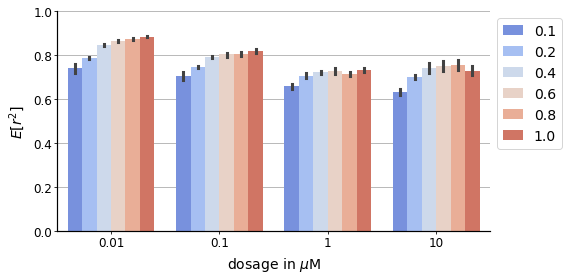

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

hue_order = [0.1, 0.2, 0.4, 0.6, 0.8, 1.]

sns.barplot(
    data=df_ss,
    x="variable",
    y="value",
    hue="fraction_to_keep",
    hue_order=hue_order,
    palette=sns.color_palette("coolwarm", n_colors=len(hue_order)),
    ax=axs,
)

x_labels = axs.get_xticklabels()
dose_labels = ["0.01", "0.1", "1", "10"]
[label.set_text(dose_labels[i]) for i, label in enumerate(x_labels)]
axs.set_xticklabels(x_labels)
axs.set_ylabel("$E[r^2]$", fontsize=14)
axs.set_xlabel("dosage in $\mu$M", fontsize=14)
axs.set_axisbelow(True)
axs.grid(".", color="darkgrey", axis="y")
axs.set_ylim(0,1)

axs.legend(
    title="",
    fontsize=14,
    title_fontsize=14,
    loc="upper left",
    frameon=True,
    bbox_to_anchor=(1, 1),
)

plt.tight_layout()
plt.savefig(FIG_DIR_LCL + "sciplex3_fractions.png", format="png", dpi=300)
plt.show()

## Ablation study of reconstruction penalty

In [15]:
df_rs0 = pd.read_csv(DATA_DIR_LCL + "reconstruct_penalty_0.csv", index_col=0)
df_rs0["type"] = "biolord "+ r"$(\tau=0)$"
df_optimal = pd.read_csv(DATA_DIR_LCL + "seed_check_biolord.csv", index_col=0) 
df_optimal["type"] = "biolord"


df_full = pd.concat([df_rs0, df_optimal])[['type', 'mean_all_biolord/0.001', 'mean_all_biolord/0.01',
       'mean_all_biolord/0.1', 'mean_all_biolord/1.0']]
df_full.head()

,type,mean_all_biolord/0.001,mean_all_biolord/0.01,mean_all_biolord/0.1,mean_all_biolord/1.0
Name,,,,,
unique-sound-7,biolord $(\tau=0)$,0.293483,0.284272,0.249824,0.196255
kind-cherry-7,biolord $(\tau=0)$,0.434744,0.411050,0.340945,0.245753
electric-resonance-9,biolord $(\tau=0)$,0.432118,0.419224,0.368575,0.293350
elated-music-9,biolord $(\tau=0)$,0.431536,0.406984,0.334667,0.237150
fearless-fire-5,biolord $(\tau=0)$,0.443250,0.424882,0.360646,0.264802


In [16]:
df_fmelt = pd.melt(df_full, id_vars=["type"], value_vars=['mean_all_biolord/0.001', 'mean_all_biolord/0.01',
       'mean_all_biolord/0.1', 'mean_all_biolord/1.0'])

In [17]:
df_full.groupby(by=["type"]).mean()

,mean_all_biolord/0.001,mean_all_biolord/0.01,mean_all_biolord/0.1,mean_all_biolord/1.0
type,,,,
biolord,0.881238,0.808281,0.725169,0.739689
biolord $(\tau=0)$,0.416917,0.398032,0.337236,0.251646


In [18]:
df_full.groupby(by=["type"]).var()

,mean_all_biolord/0.001,mean_all_biolord/0.01,mean_all_biolord/0.1,mean_all_biolord/1.0
type,,,,
biolord,0.000016,0.000087,0.000088,0.000611
biolord $(\tau=0)$,0.002069,0.001727,0.001092,0.000869


## Embedding uncertainty

In [19]:
adata = sc.read(
    DATA_DIR_LCL + "sciplex3_biolord.h5ad",
    backup_url="https://figshare.com/ndownloader/files/39324305",
)

In [20]:
biolord.Biolord.setup_anndata(
    adata,
    ordered_attributes_keys=["rdkit2d_dose"],
    categorical_attributes_keys=["cell_type"],
    retrieval_attribute_key=None,
)

INFO     Generating sequential column names                                                                        


In [21]:
dir_path=DATA_DIR_LCL + "sciplex3_model/"
model = biolord.Biolord.load(
    dir_path =dir_path,
    adata = adata
)

INFO     File                                                                                                      
         /cs/labs/mornitzan/zoe.piran/research/projects/biolord_data/output/perturbations-celltype/sciplex3_model_n
         ew2/model.pt already downloaded                                                                           


[rank: 0] Global seed set to 8


In [22]:
adata_high = adata[adata.obs["dose"].isin([10000])].copy()

In [23]:
rdkit2d_vals_high = []
pathways2 = []
pathways1 = []
drugs = []

for drug in adata_high.obs["drug_dose_name"].cat.categories:
    rdkit2d_vals_high.append(
        list(
            adata_high[adata_high.obs["drug_dose_name"].isin([drug])].obsm[
                "rdkit2d_dose"
            ][0, :]
        )
    )
    pathways2.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["pathway_level_2"]
        .cat.categories[0]
    )
    pathways1.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["pathway_level_1"]
        .cat.categories[0]
    )
    drugs.append(
        adata_high[adata_high.obs["drug_dose_name"].isin([drug])]
        .obs["product_name"]
        .cat.categories[0]
    )

rdkit2d_vals_high = np.asarray(rdkit2d_vals_high)
pathways1_groups = pd.Series(pathways1)
pathways1_groups[~pd.Series(pathways1).isin(groups)] = "NA"
pathways2_groups = pd.Series(pathways2)
pathways2_groups[~pd.Series(pathways2).isin(["Histone deacetylation"])] = "NA"
pathways1 = pd.Series(pathways1)
pathways1_groups[pathways1_groups == "Epigenetic regulation"] = pathways2_groups[
    pathways1_groups == "Epigenetic regulation"
]

drugs_ood = pd.Series(drugs)
drugs_ood[~pd.Series(drugs).isin(ood_drugs)] = "Observed"
drugs_ood[pd.Series(drugs).isin(ood_drugs)] = "Unseen"

In [24]:
# Get embedding
transf_embeddings_latent = model.get_ordered_attribute_embedding(
    attribute_key="rdkit2d_dose", vals=np.asarray(rdkit2d_vals_high)
)

In [25]:
# biolord
adata_emb = anndata.AnnData(X=transf_embeddings_latent, dtype=transf_embeddings_latent.dtype)
adata_emb.obs_names = drugs
adata_emb.obs["pathways"] = pathways1_groups.values

In [26]:
biolord.ul.compute_uncertainty(adata_emb, "pathways")
df_unc = pd.DataFrame(adata_emb.obs["uncertainty"].copy())

         Falling back to preprocessing with `sc.pp.pca` and default params.


/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/cs/labs/mornitzan/zoe.piran/venvjax/lib/python3.9/site-packages/uma

In [27]:
# rdkit
adata_emb_rd = anndata.AnnData(X=rdkit2d_vals_high[:, :-1], dtype=rdkit2d_vals_high[:, :-1].dtype)
adata_emb_rd.obs_names = drugs
adata_emb_rd.obs["pathways"] = pathways1_groups.values

In [28]:
biolord.ul.compute_uncertainty(adata_emb_rd, "pathways")
df_unc["RDKit"] = adata_emb_rd.obs["uncertainty"].copy().values

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [29]:
df_unc = df_unc.rename(columns = {"uncertainty": "biolord"})

In [30]:
df_melt = pd.melt(df_unc.reset_index(),  id_vars=["index"], value_vars=df_unc.columns)
df_melt = df_melt.rename(columns= {"variable": "method", "value": "Uncertainty"})

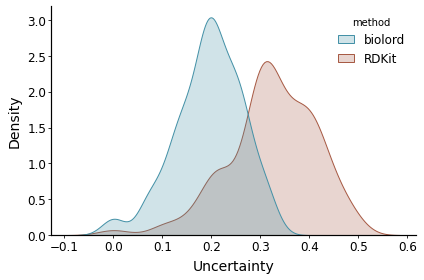

In [31]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

kde = sns.kdeplot(data=df_melt, x="Uncertainty", hue="method", palette=["#4491a7", "#a75a44"], ax=axs, fill=True, legend=True)
ll = kde.get_legend()
ll.set_label("")

plt.tight_layout()


plt.savefig(FIG_DIR_LCL + "hist_uncertainty.png", format="png", dpi=300)
plt.show()

In [32]:
df_melt.groupby("method").mean("Uncertainty")

,Uncertainty
method,
RDKit,0.322625
biolord,0.194145


In [33]:
df_melt.groupby("method").agg("Uncertainty").var()

method
RDKit      0.007949
biolord    0.004663
Name: Uncertainty, dtype: float64